논문용

정확도 평균 0.9652

train:valid = valid외:sub별 emo 7개

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

In [2]:
batch_size=32
epochs=90
num_workers=8  #16안좋은듯
learning_rate =0.1 #1e-5(X)

In [3]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        # transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
datasetDirectory_path = 'C:\\Users\\yj\\Desktop\\Task\\Trasnfer_Learning\\dataset_per_sub'#sub별 정서이미지폴더 리스트(폴더명)

# datasetDirectory_path=os.path.join(current_dir, data_dir)
datasetDirectory_list = os.listdir(datasetDirectory_path)
print(len(datasetDirectory_list), datasetDirectory_list)

74 ['F1', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F2', 'F20', 'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F3', 'F30', 'F31', 'F32', 'F33', 'F34', 'F35', 'F36', 'F37', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'M1', 'M10', 'M11', 'M12', 'M13', 'M14', 'M15', 'M16', 'M17', 'M18', 'M19', 'M2', 'M20', 'M21', 'M22', 'M23', 'M24', 'M25', 'M26', 'M27', 'M28', 'M29', 'M3', 'M30', 'M31', 'M32', 'M33', 'M34', 'M35', 'M36', 'M37', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']


In [5]:
dataloaders_set = []
dataset_sizes_set = []

for i in range(len(datasetDirectory_list)):
    sub = datasetDirectory_list[i]

    path = {x: os.path.join(datasetDirectory_path, datasetDirectory_list[i], x)  for x in ['train', 'valid']} 

    image_datasets = {x: datasets.ImageFolder(path[x],
                                          data_transforms[x])
                                    for x in ['train', 'valid']}
    # print('image_datasets========== ', image_datasets)
    
    dataloaders = { 'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers, pin_memory=True),
                'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size=1,
                                             shuffle=False, num_workers=num_workers, pin_memory=True) }
    # print('dataloaders=========', dataloaders)
    dataloaders_set.append(dataloaders)
    
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
    dataset_sizes_set.append(dataset_sizes)
    
# print('dataloaders_set', dataloaders_set)
# print()
# print('dataset_sizes', dataset_sizes)
# print('dataset_sizes_set', dataset_sizes_set)
# print(dataloaders_set)
dataset_sizes
dataset_sizes_set

class_names = image_datasets['train'].classes
class_names

['AN', 'DI', 'FE', 'HA', 'NE', 'SA', 'SU']

In [6]:
print(image_datasets['train'])

Dataset ImageFolder
    Number of datapoints: 511
    Root location: C:\Users\yj\Desktop\Task\Trasnfer_Learning\dataset_per_sub\M9\train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [7]:
print(image_datasets['train'][0][0].shape)
print(image_datasets['train'][0][0].size())


print(image_datasets['train'].__getitem__(0)[0].size(), image_datasets['train'].__len__())
print(image_datasets['valid'].__getitem__(0)[0].size(), image_datasets['valid'].__len__())

print(len(image_datasets['train']), len(image_datasets['valid']))
# print(image_datasets['train'][0])

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224]) 511
torch.Size([3, 224, 224]) 7
511 7


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import numpy as np
import random
import os

def seed_everywhere(seed: int = 42):
    random.seed(seed) # random 파이썬 자체 모듈 랜덤 모듈의 시드 고정
    np.random.seed(seed) # numpy를 사용할 경우 고정
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    # pytorch
    torch.manual_seed(seed) #torch를 거치는 모든 난수들의 생성순서를 고정한다
    torch.cuda.manual_seed(seed) #cuda를 사용하는 메소드들의 난수시드는 따로 고정해줘야한다.
    torch.backends.cudnn.deterministic = True #딥러닝에 특화된 cudnn의 난수시드 고정
    torch.backends.cudnn.benchmark = False 

seed = 42
seed_everywhere(seed)

cuda:0


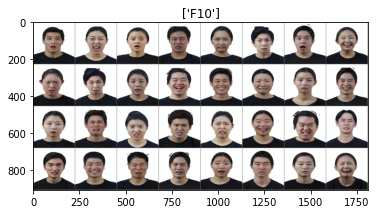

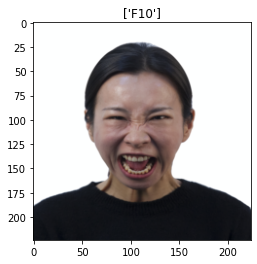

In [9]:
# 일부 이미지 시각화하기
import torchvision
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.

    
for subject, one_dataloaders in list(zip(datasetDirectory_list, dataloaders_set))[1:2]:
    # print(subject, one_dataloaders)
    train_inputs, train_classes = next(iter(one_dataloaders['train']))
    valid_inputs, valid_classes = next(iter(one_dataloaders['valid']))
    # print(inputs, classes) 
    
    out = torchvision.utils.make_grid(train_inputs)
    imshow(out, title=[subject])
    
    out = torchvision.utils.make_grid(valid_inputs)
    imshow(out, title=[subject])

In [10]:
# 모델 학습하기
import time
import copy

def train_model(sub, one_dataloaders, model, criterion, optimizer, scheduler, num_epoch=epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # print(sub, one_dataloaders)
    # print('[ {} Training Start ]===================================================='.format(sub))

    for epoch in range(epochs):
        # print('[ {} Training Start ]'.format(sub))
        # print('[{}] Epoch {}/{}'.format(sub, epoch, epochs))
        # print(f'Epoch {epoch}/{epochs - 1}')
        # print('-' * 50)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다. #학습데이터셋 다하고 검증데이터셋하는 순서
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정
                # print('[ {} Validation Start ]'.format(sub))  # val폴더에서 1개씩 모두 랜덤으로 로드함.

            running_loss = 0.0
            running_corrects = 0


            # 데이터를 반복
            n=1
            for inputs, labels in one_dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                    
                
                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파 # 학습 시에만 연산 기록을 추적                
                with torch.set_grad_enabled(phase == 'train'):
                    # print('{} {}/{} [{} / {} Batch] ===================================================================='.format(sub, epoch, epochs, n, len(one_dataloaders['train'])))
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) # 클래스에서 가장 높은 예측수치값과 인덱스 출력해서 예측수치값버리고 인덱스값만 preds로 저장 # 마지막 layer에서 가장 값이 큰 1개의 class를 예측 값으로 지정

                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화 # training 모드에서는 weight를 update한다.
                    if phase == 'train': 
                        loss.backward()
                        optimizer.step()       

                # 통계
                #한 에폭당 총로스값 
                running_loss += loss.item() * inputs.size(0) # running_loss= 손실의 스칼라값(loss.item())에 배치사이즈(inputs.size(0)) 곱함 (한 배치 로스)

                #한 에폭당 총 맞힌개수
                running_corrects += torch.sum(preds == labels.data) # 배치당 정답 맞춘 갯수 더하기

                n+=1

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase] # epoch_loss:한 에폭동안 다 더한 총로스값(running_loss)을 train이미지 개수(dataset_sizee[phase])로 나눔 #1198.6277075707912/511
            epoch_acc = running_corrects.double() / dataset_sizes[phase] # epoch_acc:한 에폭당 총 맞힌 개수/이미지 개수
            # print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'valid' and epoch_acc > best_acc:
                # print('Val label: ', labels.data)
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        # print()


    time_elapsed = time.time() - since
    # print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'{sub} Best valid Acc: {best_acc:4f}')
    n=0

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)

    # model_save_dir = 'saved_model/' +sub+ '.pth'
    torch.save(model.state_dict(), model_save_dir+ '/' +sub+ '_model.pth')
    print('model_save_dir:', model_save_dir)

    return model

In [11]:
# # 모델 예측값 시각화하기
# def visualize_model(model, num_images=6):
#     was_training = model.training
#     model.eval()
#     images_so_far = 0
#     fig = plt.figure()

#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloaders['valid']):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)

#             for j in range(inputs.size()[0]):
#                 images_so_far += 1
#                 ax = plt.subplot(num_images//2, 2, images_so_far)
#                 ax.axis('off')
#                 # ax.set_title(f'predicted: {class_names[preds[j]]}')
#                 ax.set_title(f'predicted: {class_names[preds[j]]}' + ', '    +f'True: {class_names[labels[j]]}' )
                
#                 imshow(inputs.cpu().data[j])

#                 if images_so_far == num_images:
#                     model.train(mode=was_training)
#                     return
#         model.train(mode=was_training)

In [12]:
model_conv = models.resnet152(pretrained=True)
for param in model_conv.parameters(): # False로 설정함으로써 마지막 classifier를 제외한 모든 부분을 고정하여 backward()중에 경사도 계산이 되지 않도록 합니다.
    param.requires_grad = False #model_conv객체의 parameter()에 모든 param들을 훈련못하도록 False해준다

num_ftrs = model_conv.fc.in_features #모델의 마지막 레이어의 출력노드 갯수를 구해주는 함수.
model_conv.fc = nn.Linear(num_ftrs, 7) #len(class_names) #Pretrained모델의 끝단에 fc레이어를 추가로 삽입하고 노드(클래스수)를 연결시킨 것이 사용할 모델.
# FC레이어, linear레이어의 출력노드 갯수는 클래스의 갯수와 같다.(1000개에서 7개로 분류해주는 num_ftrs의 fc_layer=required_grad=True상태로 나온다)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=learning_rate, momentum=0.9,
                                 weight_decay=0.0001)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=30, gamma=0.1)

In [13]:
import time
import datetime
from datetime import datetime
start_time = time.time()

for sub, one_dataloaders  in list(zip(datasetDirectory_list, dataloaders_set))[:]:
    # print(sub, one_dataloaders)
    work_date = datetime.today().strftime("%Y%m%d_%H%M%S")
    model_save_dir = './saved_model/{}/'.format(sub) + work_date  # ./saved_model/2021712)
    # print('model_save_dir:', model_save_dir)
    print()


    def createFolder(directory):
        try:
            if not os.path.exists(directory):
                os.makedirs(directory)
        except OSError:
            print('Error: Creating directory. ' + directory)    
    createFolder(model_save_dir)

    model_conv = train_model(sub, one_dataloaders, model_conv, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epoch=epochs)


F1 Best valid Acc: 0.714286
model_save_dir: ./saved_model/F1/20220523_083635

F10 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F10/20220523_085731

F11 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F11/20220523_092638

F12 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F12/20220523_095711

F13 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F13/20220523_102726

F14 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F14/20220523_105005

F15 Best valid Acc: 0.857143
model_save_dir: ./saved_model/F15/20220523_111056

F16 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F16/20220523_113145

F17 Best valid Acc: 0.714286
model_save_dir: ./saved_model/F17/20220523_115220

F18 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F18/20220523_121312

F19 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F19/20220523_123417

F2 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F2/20220523_125516

F20 Best valid Acc: 1.000000
model_save_dir


F1 Best valid Acc: 0.714286
model_save_dir: ./saved_model/F1/20220523_083635

F10 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F10/20220523_085731

F11 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F11/20220523_092638

F12 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F12/20220523_095711

F13 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F13/20220523_102726

F14 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F14/20220523_105005

F15 Best valid Acc: 0.857143
model_save_dir: ./saved_model/F15/20220523_111056

F16 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F16/20220523_113145

F17 Best valid Acc: 0.714286
model_save_dir: ./saved_model/F17/20220523_115220

F18 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F18/20220523_121312

F19 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F19/20220523_123417

F2 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F2/20220523_125516

F20 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F20/20220523_132209

F21 Best valid Acc: 0.857143
model_save_dir: ./saved_model/F21/20220523_135141

F22 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F22/20220523_142245

F23 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F23/20220523_145347

F24 Best valid Acc: 0.857143
model_save_dir: ./saved_model/F24/20220523_152455

F25 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F25/20220523_155511

F26 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F26/20220523_162912

F27 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F27/20220523_171352

F28 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F28/20220523_175731

F29 Best valid Acc: 0.857143
model_save_dir: ./saved_model/F29/20220523_183841

F3 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F3/20220523_190857

F30 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F30/20220523_193904

F31 Best valid Acc: 0.857143
model_save_dir: ./saved_model/F31/20220523_200920

F32 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F32/20220523_203930

F33 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F33/20220523_210944

F34 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F34/20220523_213915

F35 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F35/20220523_220925

F36 Best valid Acc: 0.857143
model_save_dir: ./saved_model/F36/20220523_223941

F37 Best valid Acc: 0.571429
model_save_dir: ./saved_model/F37/20220523_230953

F4 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F4/20220523_234006

F5 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F5/20220524_001022

F6 Best valid Acc: 0.857143
model_save_dir: ./saved_model/F6/20220524_004035

F7 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F7/20220524_011043

F8 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F8/20220524_014059

F9 Best valid Acc: 1.000000
model_save_dir: ./saved_model/F9/20220524_021119

M1 Best valid Acc: 0.857143
model_save_dir: ./saved_model/M1/20220524_024130

M10 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M10/20220524_031148

M11 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M11/20220524_034208

M12 Best valid Acc: 0.857143
model_save_dir: ./saved_model/M12/20220524_041225

M13 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M13/20220524_044243

M14 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M14/20220524_051258

M15 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M15/20220524_054322

M16 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M16/20220524_061343

M17 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M17/20220524_064400

M18 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M18/20220524_071423

M19 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M19/20220524_074453

M2 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M2/20220524_081520

M20 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M20/20220524_085527

M21 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M21/20220524_094002

M22 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M22/20220524_102501

M23 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M23/20220524_111029

M24 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M24/20220524_115513

M25 Best valid Acc: 0.857143
model_save_dir: ./saved_model/M25/20220524_124057

M26 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M26/20220524_132531

M27 Best valid Acc: 0.857143
model_save_dir: ./saved_model/M27/20220524_141040

M28 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M28/20220524_145526

M29 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M29/20220524_153922

M3 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M3/20220524_162420

M30 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M30/20220524_170905

M31 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M31/20220524_175241

M32 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M32/20220524_183615

M33 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M33/20220524_191946

M34 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M34/20220524_200300

M35 Best valid Acc: 0.857143
model_save_dir: ./saved_model/M35/20220524_204644

M36 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M36/20220524_213025

M37 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M37/20220524_221412

M4 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M4/20220524_225822

M5 Best valid Acc: 0.714286
model_save_dir: ./saved_model/M5/20220524_234207

M6 Best valid Acc: 0.857143
model_save_dir: ./saved_model/M6/20220525_002603

M7 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M7/20220525_010945

M8 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M8/20220525_015337

M9 Best valid Acc: 1.000000
model_save_dir: ./saved_model/M9/20220525_023731